This code is partially adapted from https://arxiv.org/abs/2210.07881

In [746]:
import numpy as np
import matplotlib.pyplot as plt
import math

from topology_util import *
from EquiTopo import *

np.random.seed(123)

In [747]:
# CECA-2P
def OptTopos(n):
    tau = int(math.ceil(math.log(n, 2.0))) 
    print(tau)
    bi = bin(n - 1)
    n_ex = 0
    Ws = np.zeros((tau, 2 * n, 2 * n))
    Wgs = np.zeros((tau, 2 * n, 2 * n))
    for k in range(tau):
        d = int(bi[2 + k])
        P = np.zeros((n, n))
        if d == 1:
            for j in range(n):
                i = (j + n_ex + 1) % n
                P[i, j] = 1
            
            Ws[k, :n, :n] = 0.5 * np.eye(n) + 0.5 * P
            Ws[k, :n, n:] = 0
            Ws[k, n:, :n] = (n_ex + 1) * P / (2 * n_ex + 1)
            Ws[k, n:, n:] = n_ex * np.eye(n) / (2 * n_ex + 1)
            Wgs[k, :n, :n] = 0.5 * np.eye(n) + 0.5 * P
            Wgs[k, :n, n:] = 0
            Wgs[k, n:, :n] = (n_ex + 1) * P / (2 * n_ex + 1) + n_ex * np.eye(n) / (2 * n_ex + 1)
            Wgs[k, n:, n:] = 0
        
        if d == 0:
            for j in range(n):
                i = (j + n_ex) % n
                P[i, j] = 1
            
            Ws[k, :n, :n] = (n_ex + 1) * np.eye(n) / (2 * n_ex + 1)
            Ws[k, :n, n:] = n_ex * P / (2 * n_ex + 1)
            Ws[k, n:, :n] = 0
            Ws[k, n:, n:] = 0.5 * np.eye(n) + 0.5 * P
            Wgs[k, :n, :n] = 0
            Wgs[k, :n, n:] = (n_ex + 1) * np.eye(n) / (2 * n_ex + 1) + n_ex * P / (2 * n_ex + 1)
            Wgs[k, n:, :n] = 0
            Wgs[k, n:, n:] =  0.5 * np.eye(n) + 0.5 * P
        n_ex = 2 * n_ex + d
    return Ws, Wgs

In [748]:
# CECA-1P
def OptToposOne(n):
    tau = int(math.ceil(math.log(n, 2.0))) 
    print(tau)
    bi = bin(n - 1)
    n_ex = 0
    Ws = np.zeros((tau, 2 * n, 2 * n))
    Wgs = np.zeros((tau, 2 * n, 2 * n))
    for k in range(tau):
        d = int(bi[2 + k])
        P = np.zeros((n, n))
        if d == 1:
            for j in range(n):
                if j % 2 == 1:
                    i = (j + 2 * n_ex + 1) % n
                    P[i, j] = 1
                    P[j, i] = 1
            
            Ws[k, :n, :n] = 0.5 * np.eye(n) + 0.5 * P
            Ws[k, :n, n:] = 0
            Ws[k, n:, :n] = (n_ex + 1) * P / (2 * n_ex + 1)
            Ws[k, n:, n:] = n_ex * np.eye(n) / (2 * n_ex + 1)
            Wgs[k, :n, :n] = 0.5 * np.eye(n) + 0.5 * P
            Wgs[k, :n, n:] = 0
            Wgs[k, n:, :n] = (n_ex + 1) * P / (2 * n_ex + 1) + n_ex * np.eye(n) / (2 * n_ex + 1)
            Wgs[k, n:, n:] = 0
        
        if d == 0:
            for j in range(n):
                if j % 2 == 1:
                    i = (j + 2 * n_ex + 1) % n
                    P[i, j] = 1
                    P[j, i] = 1
            
            Ws[k, :n, :n] = (n_ex + 1) * np.eye(n) / (2 * n_ex + 1)
            Ws[k, :n, n:] = n_ex * P / (2 * n_ex + 1)
            Ws[k, n:, :n] = 0
            Ws[k, n:, n:] = 0.5 * np.eye(n) + 0.5 * P
            Wgs[k, :n, :n] = 0
            Wgs[k, :n, n:] = (n_ex + 1) * np.eye(n) / (2 * n_ex + 1) + n_ex * P / (2 * n_ex + 1)
            Wgs[k, n:, :n] = 0
            Wgs[k, n:, n:] =  0.5 * np.eye(n) + 0.5 * P
        n_ex = 2 * n_ex + d
    return Ws, Wgs

### Problem

Assume the network size is $n$. At each agent/node $i$, the distributed least square problems are defined by
$$f_i(x):=||A_i x - b_i||^2,$$
where $x\in\mathbb{R}^d$ and $A_i\in \mathbb{K\times d}$. The parameter $K$ is the local data size. In this experiment, we generate elements in $A_i$ from a standard normal distribution. For given $x$, the label $b_i$ is generated by $b_i = A_i x + s_i$, where $s_i\sim \mathcal{N}(0, \sigma_s^2 I)$ is a white noise.

In [148]:
# Gradient utility
def ls_full_grad_dist(X, y, W):
    
    n, m = X.shape
    Q = W.shape[0]
    N_agent = n//Q    
    
    G = np.zeros((Q, m))
    
    for k in range(Q):
        
        wk = W[k,:].reshape(m, 1)        
        Xk = X[k*N_agent:(k+1)*N_agent, :]
        yk = y[k*N_agent:(k+1)*N_agent].reshape(N_agent, 1)

        grad = Xk.T@(Xk@wk-yk)
        G[k,:] = grad.T
    
    return G

In [532]:
# Data generation utility
# Sigma_n is set to be 0.1.
# N = K * n 
def genLS(N, d):

    A = np.random.randn(N, d)
    b = A @ np.random.randn(d, 1) + 0.1 * np.random.randn(N, 1)
    return A, b

In [150]:
# Solution utility
def solLS(A, b):
    x_sol = np.linalg.inv(A.T@A)@(A.T@b)
    print(A.T@(A@x_sol-b))
    return x_sol

Here, we use decentralized SGD to solve this problem by generating a stochastic gradient via
$$\widehat{\nabla f_i}(x) = \nabla f_i(x) + n_i,$$
where $n_i\sim \mathcal{N}(0, \sigma_n^2 I)$ is a white gradient noise.

In [556]:
# DSGD -- traning utility 
def train_opt(n, d, X_sol, A, b, Ws, Wgs, noise_mag, maxite, mu_init, exp_repeat, mu_decay=0, mu_min=0, period=10000):
    DSGD_loss_record_ave = np.zeros((maxite, 1))

    for e in range(exp_repeat):

        DSGD_loss_record = np.zeros((maxite, 1))

        print("DSGD Repeat:", e)
        tau = int(math.ceil(math.log(n, 2.0))) 
        bi = bin(n - 1)
        X = np.zeros((n, d))
        # X = np.random.normal(0, 0.1, (n, d))
        X_bar = np.copy(X)
        Y = np.zeros((2*n, d))
        Y[:n] = np.copy(X)
        Y[n:] = np.copy(X_bar)
        mu = mu_init
        
        for ite in range(maxite):

            if (ite+1)%period == 0:
                #mu = mu/mu_decay
                #mu = max(mu, mu_min)
                print ('DSGD iteration:', ite)

            t = ite % tau
            W = Ws[t]
            Wg = Wgs[t]
            dig = int(bi[2 + t])
            G = np.zeros((2*n, d))
            if dig == 1:
                G[:n] = ls_full_grad_dist(A, b, X)
                #print(G[:n])
            else:
                G[n:] =  ls_full_grad_dist(A, b, X_bar)
               
            V = np.random.randn(2*n, d)  # Gaussian noise

            Y = W @ Y - mu * Wg @ (G + noise_mag*V)
            X = np.copy(Y[:n])
           
            X_bar = np.copy(Y[n:])

            # record loss
            DSGD_loss_record[ite] = np.linalg.norm(X-X_sol,'fro')/np.linalg.norm(X_sol,'fro')
            
        DSGD_loss_record_ave += DSGD_loss_record
           
    DSGD_loss_record_ave = DSGD_loss_record_ave/exp_repeat
    return DSGD_loss_record_ave 


In [638]:
# DSGD -- traning utility 
def train_dynamic(n, d, X_sol, A, b, Ws, noise_mag, maxite, mu_init, exp_repeat, mu_decay=0, mu_min=0, period=10000, seed=0, eta=1, method=None, Ms=None):
    DSGD_loss_record_ave = np.zeros((maxite, 1))

    for e in range(exp_repeat):

        DSGD_loss_record = np.zeros((maxite, 1))

        print("DSGD Repeat:", e)
        X = np.zeros((n, d))
        # X = np.random.normal(0, 0.1, (n, d))

        mu = mu_init
        rng = np.random.default_rng(seed)
        for ite in range(maxite):

            if (ite+1)%period == 0:
                #mu = mu/mu_decay
                #mu = max(mu, mu_min)
                print ('DSGD iteration:', ite)
            if method == 'ExpGraph':
                W = Ws[int(ite % len(Ws))]
            elif method == 'ODEquiDynComplete':
                
                W = ODEquiDyn(n, Ms, eta, rng)
            elif method == 'OUEquiDynComplete':
                W = OUEquiDyn(n, Ms, eta, rng)

            G = ls_full_grad_dist(A, b, X)
            #print(G)
            V = np.random.randn(n, d)  # Gaussian noise
            X = W @ (X - mu * (G + noise_mag*V))
            


            # record loss
            DSGD_loss_record[ite] = np.linalg.norm(X-X_sol,'fro')/np.linalg.norm(X_sol,'fro')
            
        DSGD_loss_record_ave += DSGD_loss_record
           
    DSGD_loss_record_ave = DSGD_loss_record_ave/exp_repeat
    return DSGD_loss_record_ave 


In [341]:
# DSGD -- traning utility 
def train_static(n, d, X_sol, A, b, W, noise_mag, maxite, mu_init, exp_repeat, mu_decay=0, mu_min=0, period=10000):
    DSGD_loss_record_ave = np.zeros((maxite, 1))

    for e in range(exp_repeat):

        DSGD_loss_record = np.zeros((maxite, 1))

        print("DSGD Repeat:", e)
        X =  np.zeros((n, d))
        # X = np.random.normal(0, 0.1, (n, d))
        mu = mu_init
        
        for ite in range(maxite):

            if (ite+1)%period == 0:
                #mu = mu/mu_decay
                #mu = max(mu, mu_min)
                print ('DSGD iteration:', ite)

            G = ls_full_grad_dist(A, b, X)
            V = np.random.randn(n, d)  # Gaussian noise
            X = W @ (X - mu * (G + noise_mag*V))

            # record loss
            DSGD_loss_record[ite] = np.linalg.norm(X-X_sol,'fro')/np.linalg.norm(X_sol,'fro')
            
        DSGD_loss_record_ave += DSGD_loss_record
           
    DSGD_loss_record_ave = DSGD_loss_record_ave/exp_repeat
    return DSGD_loss_record_ave 


#### Parameters

In [728]:
# network size
n= 258
# number of features
d = 10
# local data size is 50
N = n * 50

noise_mag = 5
maxite = 50
mu_init = 0.0245
exp_repeat = 5


#### Generating data

In [739]:
A, b = genLS(N, d)
x_sol = solLS(A, b)
X_sol = np.ones((n,1))@x_sol.T

[[-1.06314957e-12]
 [-6.82565116e-13]
 [ 1.42241774e-12]
 [ 1.74971149e-13]
 [ 1.71596071e-11]
 [ 8.98336960e-13]
 [ 9.27080634e-12]
 [-7.20956628e-12]
 [-8.47766302e-13]
 [-9.53193080e-12]]


In [ ]:
Ws, Wgs = OptTopos(n)
loss = train_opt(n, d, X_sol, A, b, Ws, Wgs, noise_mag, maxite, mu_init, exp_repeat)

In [ ]:
Ws, Wgs = OptToposOne(n)
one_loss = train_opt(n, d, X_sol, A, b, Ws, Wgs, noise_mag, maxite, mu_init, exp_repeat)


In [ ]:
Ws = OnePeer_ExponentialGraph(n)
loss_onexp = train_dynamic(n, d, X_sol, A, b, Ws, noise_mag, maxite, 0.024, exp_repeat, method='ExpGraph')
M = math.log2(n) 
M = int(M) - 1
A_undi, Ms1 = UEquiStatic(n, seed=0, M=M)
A_di, Ms2 = DEquiStatic(n, seed=0, M=M)
loss_OU = train_dynamic(n, d, X_sol, A, b, Ws, noise_mag, maxite, mu_init, exp_repeat, method='OUEquiDynComplete', Ms=Ms1)
loss_OD = train_dynamic(n, d, X_sol, A, b, Ws, noise_mag, maxite, mu_init, exp_repeat, method='ODEquiDynComplete', Ms=Ms2)


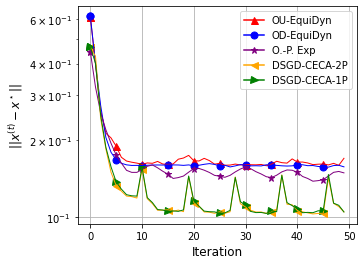

In [745]:
# plot the results
plt.rcParams['figure.figsize'] = 5, 4
plt.figure()
xlen = maxite

plt.semilogy(0, loss_OU[0], color='red', marker='^', markersize = 7)
plt.semilogy(0, loss_OD[0], color='blue', marker='o', markersize = 7)
plt.semilogy(0, loss_onexp[0], color='purple', marker='*', markersize = 7)
plt.semilogy(0, loss[0], color='orange', marker='<', markersize = 7)
plt.semilogy(0, one_loss[0], color='green', marker='>', markersize = 7)


idx_set = np.arange(0, xlen, xlen//10)
plt.semilogy(idx_set, loss_OU[idx_set], color='red', marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, loss_OD[idx_set], color='blue', marker='o', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, loss_onexp[idx_set], color='purple', marker='*', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, loss[idx_set], color='orange', marker='<', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, one_loss[idx_set], color='green', marker='>', markersize = 7, linestyle = 'None')

plt.semilogy(np.arange(xlen), loss_OU, linewidth=1.0, color='red')
plt.semilogy(np.arange(xlen), loss_OD, linewidth=1.0, color='blue')
plt.semilogy(np.arange(xlen), loss_onexp, linewidth=1.0, color='purple')
plt.semilogy(np.arange(xlen), loss, linewidth=1.0, color='orange')
plt.semilogy(np.arange(xlen), one_loss, linewidth=1.0, color='green')


plt.legend(['OU-EquiDyn', 'OD-EquiDyn', 'O.-P. Exp', 'DSGD-CECA-2P', 'DSGD-CECA-1P' ], fontsize=10)
plt.xlabel('Iteration', fontsize = 12)
plt.ylabel(r'$||x^{(t)} - x^\star||$', fontsize = 12)
plt.grid(True)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("test.pdf", dpi=180, bbox_inches ='tight')